In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

import warnings

## Loading data

In [2]:
df = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','samples_for_model.csv'))
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year,iceplant
0,134,125,103,170,0.118421,2012,5,126,1
1,130,114,101,164,0.115646,2012,5,126,1
2,132,110,98,160,0.095890,2012,5,126,1


In [7]:
mpe.iceplant_proportions(df.iceplant)

no-iceplant:iceplant ratio     1.9 :1
          counts  percentage
iceplant                    
0         227474       66.04
1         116954       33.96



## Train rfc model

In [3]:
X_train, X_test, y_train, y_test = mpe.test_train_from_df(df)
mpe.test_train_proportions(y_train, y_test)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     1.9 :1
          counts  percentage
iceplant                    
0         159093       65.99
1          82006       34.01

TEST SET COUNTS:
no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0          68381       66.18
1          34948       33.82



In [4]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [7]:
predictions = rfc.predict(X_test)
mpe.print_threshold_metrics(y_test, predictions)


true negatives: 67103     false positives: 1278
false negatives: 1230     true positives: 33718

sensitivity (TP/P): 96.48 %
specificity (TN/N): 98.13 %
G-mean:  0.97

precision (TP/(TP+FP)): 96.35 %

MCC:  0.9457983987962804

F1-measure:  0.96414
F0.5-measure (min false positives):  0.96375
F2-measure (min false negatives)  :  0.96454

accuracy: 97.57 %



## Variable importance

In [18]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [23]:
forest_importances = pd.Series(result.importances_mean, index=['r', 'g', 'b', 'nir', 'ndvi', 'year', 'month', 'day_in_year'])

r              0.228468
g              0.089771
b              0.122555
nir            0.124716
ndvi           0.064180
year           0.065384
month          0.009816
day_in_year    0.049022
dtype: float64

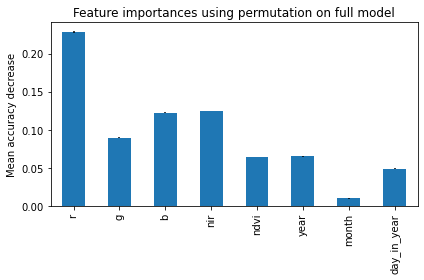

In [24]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Predictions over areas of interest

In [5]:
def features_over_aoi(item,image):

    veg = ipf.select_ndvi_df(image)
    
    veg['ndvi']=(veg.nir.astype('int16') - veg.r.astype('int16'))/(veg.nir.astype('int16') + veg.r.astype('int16'))

    veg['year'] = item.datetime.year
    veg['month'] = item.datetime.month
    veg['day_in_year'] = ipf.day_in_year(item.datetime.day, item.datetime.month, item.datetime.year)

    veg = veg[['r','g','b','nir','ndvi','year','month','day_in_year']] # order features
    return veg

# -----------------------------------------------

def predict_df(veg,rfc):

    index = veg.index
    features = np.array(veg)

    predictions_class = rfc.predict(features)
    c = {'prediction': predictions_class}
    predictions_df = pd.DataFrame(c, index = index)
    
    return predictions_df


def predict_over_aoi(itemid, aoi, rfc):
    image = ipf.open_window_in_scene(itemid, aoi)
    item = ipf.get_item_from_id(itemid)    

    veg = features_over_aoi(item, image)
    df = predict_df(veg, rfc)
    
    nrows = image.shape[1]
    ncols = image.shape[2]
    index = df[df.prediction == 1].index.to_numpy()
    
    return ipf.indices_backto_image(nrows, ncols, index)


In [6]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
#aois

## Test run on whole NAIP scene (checking processing times)

In [6]:
jldp_itemids = ['ca_m_3412037_nw_10_060_20200607',
                'ca_m_3412037_ne_10_060_20200607',
                'ca_m_3412029_sw_10_060_20200607',
                'ca_m_3412029_se_10_060_20200607']

In [7]:
k=3

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    item = ipf.get_item_from_id(jldp_itemids[k])
    rast = ipf.get_raster_from_item(item)
    scene = ipf.get_raster_from_item(item).read([1,2,3,4])
    print('retrieved scene')
    
    veg = features_over_aoi(item, scene)
    print('added features')
    
    predictions_df = predict_df(veg, rfc)
    print('made predictions')

    nrows = scene.shape[1]
    ncols = scene.shape[2]
    index = predictions_df[predictions_df.prediction == 1].index.to_numpy()
    preds = ipf.indices_backto_image(nrows,ncols, index)
    print('converted back to image')
    

retrieved scene
added features
made predictions
converted back to image


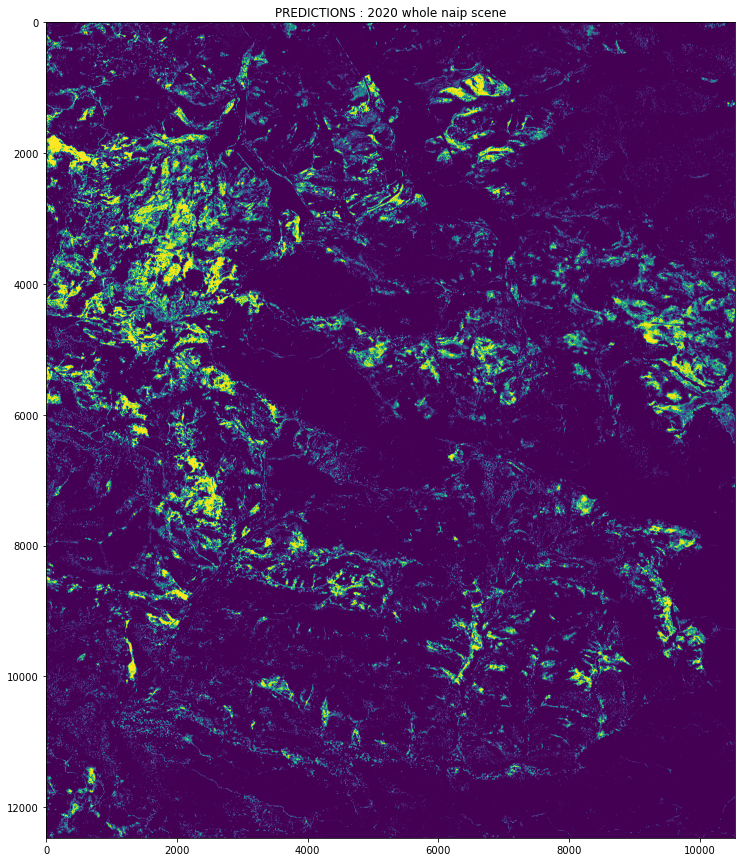

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 2020 whole naip scene")
ax.imshow(preds)
plt.show()

In [8]:
fp = os.path.join(os.getcwd(),'jldp_rasters','NAIP_2020_scene_' + str(k+1)+'.tif')

with rasterio.open(
    fp,  # file path
    'w',           # w = write
    driver='GTiff', # format
    height = preds.shape[0], 
    width = preds.shape[1],
    count = 1,  # number of raster bands in the dataset
    dtype = rasterio.uint8,
    crs = rast.crs,
    transform = rast.transform,
) as dst:
    dst.write(preds.astype(rasterio.uint8), 1)

In [ ]:
import rioxarray as rioxr

In [ ]:
ndvi_check = rioxr.open_rasterio(ndvi_fp)
#print(nir_check.shape)
ndvi_check.plot()